# EXAMPLE 001

This is the first example o PyFME. The main purpose of this example is to check if the aircraft trimmed in a given state maintains the trimmed flight condition.

The aircraft used is a Cessna 310, ISA1976 integrated with Flat Earth (euler angles).

Example with trimmed aircraft: stationary, horizontal, symmetric, wings level flight.

In [68]:
# -*- coding: utf-8 -*-

Import python libreries needed.

In [69]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Import PyFME classes

In [70]:
from pyfme.aircrafts import Cessna310
from pyfme.environment.environment import Environment
from pyfme.environment.atmosphere import ISA1976
from pyfme.environment.gravity import VerticalConstant
from pyfme.environment.wind import NoWind
from pyfme.models.systems import EulerFlatEarth
from pyfme.simulator import BatchSimulation
from pyfme.utils.trimmer import steady_state_flight_trimmer

Initialize variables

In [71]:
aircraft = Cessna310()
atmosphere = ISA1976()
gravity = VerticalConstant()
wind = NoWind()
environment = Environment(atmosphere, gravity, wind)

Initial conditions

In [72]:
TAS = 312.5 * 0.3048  # m/s
h0 = 8000 * 0.3048  # m
psi0 = 1.0  # rad
x0, y0 = 0, 0  # m
turn_rate = 0.0  # rad/s
gamma0 = 0.0  # rad

In [73]:
system = EulerFlatEarth(lat=0, lon=0, h=h0, psi=psi0, x_earth=x0, y_earth=y0)

not_trimmed_controls = {'delta_elevator': 0.05,
                        'hor_tail_incidence': 0.00,
                        'delta_aileron': 0.01 * np.sign(turn_rate),
                        'delta_rudder': 0.01 * np.sign(turn_rate),
                        'delta_t': 0.5}

controls2trim = ['delta_elevator', 'delta_aileron', 'delta_rudder', 'delta_t']

In [74]:
trimmed_ac, trimmed_sys, trimmed_env, results = steady_state_flight_trimmer(
    aircraft, system, environment, TAS=TAS, controls_0=not_trimmed_controls,
    controls2trim=controls2trim, gamma=gamma0, turn_rate=turn_rate, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1579e+01                                    1.99e+02    
       1              2         1.9246e+00      9.65e+00       2.28e-01       5.61e+00    
       2              3         3.1854e-01      1.61e+00       1.11e-01       1.35e+00    
       3              4         3.2611e-02      2.86e-01       5.17e-02       2.95e-01    
       4              5         1.0714e-03      3.15e-02       1.99e-02       4.37e-02    
       5              6         2.3389e-06      1.07e-03       4.20e-03       1.95e-03    
       6              7         1.3432e-11      2.34e-06       2.06e-04       4.66e-06    
       7              8         4.4728e-22      1.34e-11       4.94e-07       2.69e-11    
`gtol` termination condition is satisfied.
Function evaluations: 8, initial cost: 1.1579e+01, final cost 4.4728e-22, first-order optimality 2.69e-11.


In [75]:
print(results)

{'p': 0.0, 'delta_t': 0.085579768697692654, 'alpha': -0.005512602287830309, 'theta': -0.0055126022878303092, 'delta_aileron': -7.4215636227412987e-21, 'delta_elevator': 0.031307622351066232, 'delta_rudder': -4.0465529106178451e-20, 'beta': -1.6103228517641036e-20, 'w': -0.52507270851955568, 'v': -1.5338325163053079e-18, 'r': 0.0, 'ls_opt':  active_mask: array([0, 0, 0, 0, 0, 0])
        cost: 4.4727767770115721e-22
         fun: array([  2.97439383e-11,   6.57932466e-20,  -3.00415422e-12,
        -1.91339240e-20,   9.10245431e-13,   1.31794429e-19])
        grad: array([  9.56967369e-12,  -1.67692243e-18,   1.68861334e-12,
        -1.60913017e-18,  -1.59469036e-18,   3.13843918e-10])
         jac: array([[ -1.52524495e+01,  -7.31302152e-09,   7.31302152e-09,
         -7.31302152e-09,  -7.31302152e-09,   1.05515253e+01],
       [  5.65455497e-27,  -2.37579505e+01,   1.61558713e-27,
         -1.61558713e-27,   7.82855102e+00,   1.61558713e-27],
       [ -1.55836217e+02,   3.51025033e-07,

In [76]:
my_simulation = BatchSimulation(trimmed_ac, trimmed_sys, trimmed_env)

In [77]:
tfin = 150  # seconds
N = tfin * 100 + 1
time = np.linspace(0, tfin, N)
initial_controls = trimmed_ac.controls

In [78]:
controls = {}
for control_name, control_value in initial_controls.items():
    controls[control_name] = np.ones_like(time) * control_value
    
my_simulation.set_controls(time, controls)

In [79]:
par_list = ['x_earth', 'y_earth', 'height',
            'psi', 'theta', 'phi',
            'u', 'v', 'w',
            'v_north', 'v_east', 'v_down',
            'p', 'q', 'r',
            'alpha', 'beta', 'TAS',
            'F_xb', 'F_yb', 'F_zb',
            'M_xb', 'M_yb', 'M_zb']

In [80]:
my_simulation.set_par_dict(par_list)
my_simulation.run_simulation()

In [81]:
plt.style.use('ggplot')

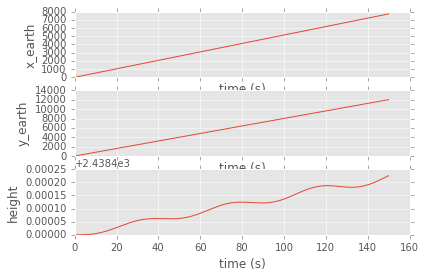

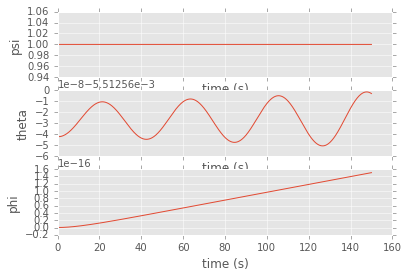

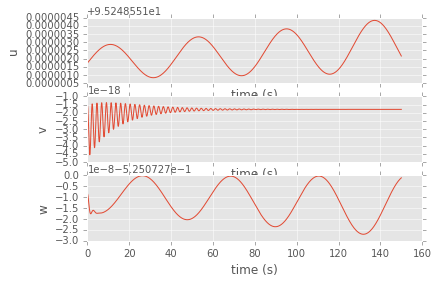

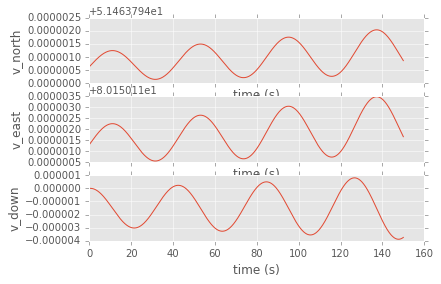

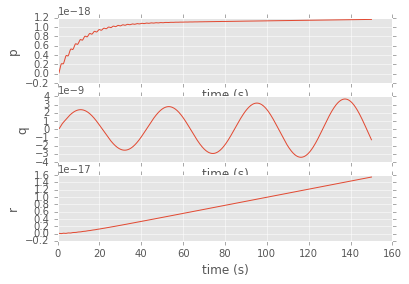

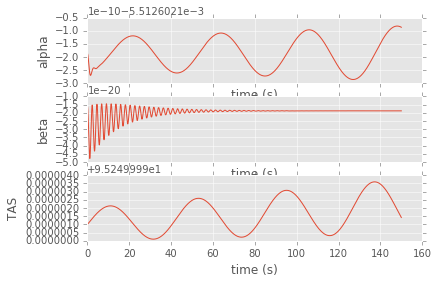

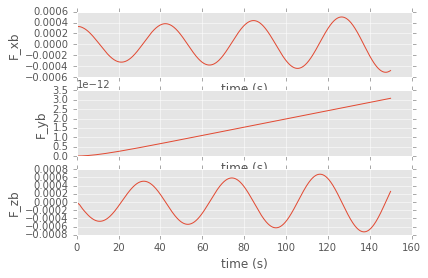

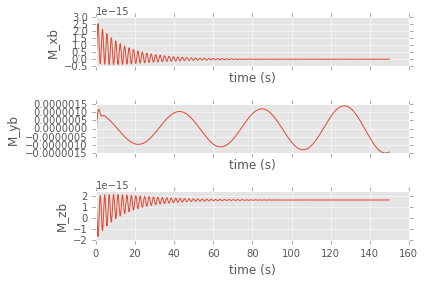

In [82]:
for ii in range(len(par_list) // 3):
    three_params = par_list[3*ii:3*ii+3]
    fig, ax = plt.subplots(3, 1, sharex=True)
    for jj, par in enumerate(three_params):
        ax[jj].plot(time, my_simulation.par_dict[par])
        ax[jj].set_ylabel(par)
        ax[jj].set_xlabel('time (s)')

fig.tight_layout()

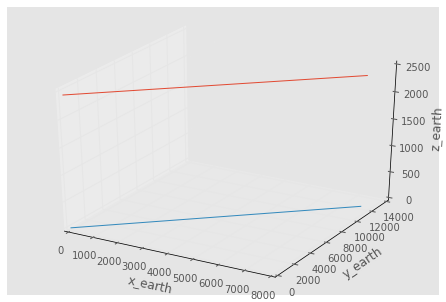

In [83]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(my_simulation.par_dict['x_earth'],
        my_simulation.par_dict['y_earth'],
        my_simulation.par_dict['height'])

ax.plot(my_simulation.par_dict['x_earth'],
        my_simulation.par_dict['y_earth'],
        my_simulation.par_dict['height'] * 0)
ax.set_xlabel('x_earth')
ax.set_ylabel('y_earth')
ax.set_zlabel('z_earth')

plt.show()